[Source](https://www.kdnuggets.com/2018/09/machine-learning-text-classification-using-spacy-python.html)

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import base64
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import string
import re
from collections import Counter
from nltk.corpus import stopwords

In [6]:
df  = pd.read_csv('research_paper.csv')
df.head()

,Title,Conference
0,Innovation in Database Management: Computer Sc...,VLDB
1,High performance prime field multiplication fo...,ISCAS
2,enchanted scissors: a scissor interface for su...,SIGGRAPH
3,Detection of channel degradation attack by Int...,INFOCOM
4,Pinning a Complex Network through the Betweenn...,ISCAS


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507 entries, 0 to 2506
Data columns (total 2 columns):
Title         2507 non-null object
Conference    2507 non-null object
dtypes: object(2)
memory usage: 19.6+ KB


In [8]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df, test_size =.33, random_state = 42)

print('Research title sample:', train['Title'].iloc[0])
print('Conference of this paper:', train['Conference'].iloc[0])
print('Training data shape:', train.shape)
print('Test data shape:', test.shape)

Research title sample: Cooperating with Smartness: Using Heterogeneous Smart Antennas in Ad-Hoc Networks.
Conference of this paper: INFOCOM
Training data shape: (1679, 2)
Test data shape: (828, 2)


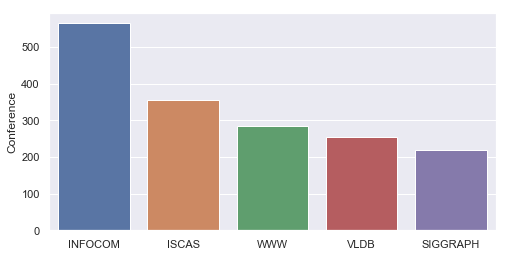

In [11]:
fig = plt.figure(figsize = (8,4))
sns.barplot(x = train['Conference'].unique(), y = train['Conference'].value_counts())

In [13]:
train['Conference'].value_counts()

ISCAS       565
INFOCOM     356
VLDB        284
WWW         254
SIGGRAPH    220
Name: Conference, dtype: int64

Text(0.5,1,'Most common words used in the research papers for conference INFOCOM ')

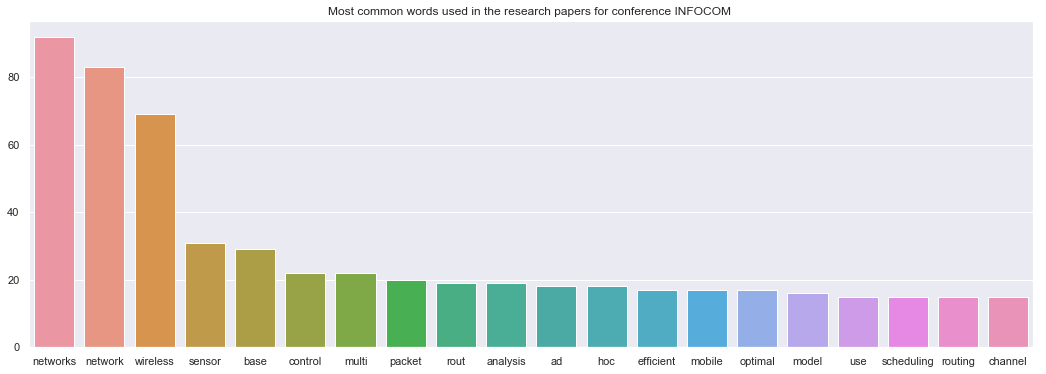

In [32]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
punctuations = string.punctuation
#stopwords = stopwords.words('english')

def cleanup_text(docs, logging = False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print('Processed %d out of %d documents.' % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable = ['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)    

INFO_text = [text for text in train[train['Conference'] == 'INFOCOM']['Title']]
IS_text = [text for text in train[train['Conference'] == 'ISCAS']['Title']]

INFO_clean = cleanup_text(INFO_text)
INFO_clean = " ".join(INFO_clean).split()

IS_clean = cleanup_text(IS_text)
IS_clean = " ".join(IS_clean).split()

INFO_counts = Counter(INFO_clean)
IS_counts = Counter(IS_clean)

INFO_common_words = [word[0] for word in INFO_counts.most_common(20)]
INFO_common_counts = [word[1] for word in INFO_counts.most_common(20)]

fig = plt.figure(figsize = (18,6))
sns.barplot(x = INFO_common_words, y = INFO_common_counts)
plt.title('Most common words used in the research papers for conference INFOCOM ')

Text(0.5,1,'Most common words used in the research papers for conference ISCAS')

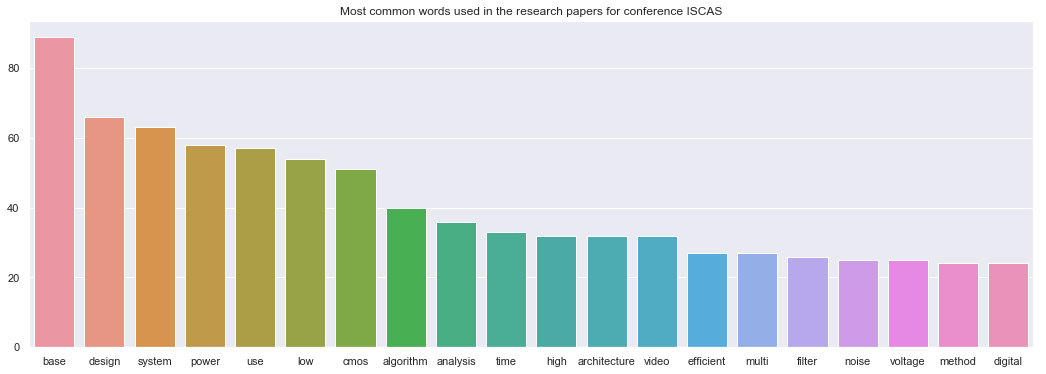

In [33]:

IS_common_words = [word[0] for word in IS_counts.most_common(20)]
IS_common_counts = [word[1] for word in IS_counts.most_common(20)]

fig = plt.figure(figsize = (18,6))
sns.barplot(x = IS_common_words, y = IS_common_counts)
plt.title('Most common words used in the research papers for conference ISCAS')

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score

from spacy.lang.en import English
parser = English()

In [49]:
STOPLIST = stopwords +list(ENGLISH_STOP_WORDS)
SYMBOLS = " ".join(string.punctuation).split(" ") +["-","...","''"]

class CleanTextTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep = True):
        return {}
    
def cleanText(text):
    text = text.strip().replace('\n', " ").replace("\r", " ")
    text = text.lower()
    return text
    
def tokenizeText(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens


In [52]:
def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N+1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)
        
vectorizer = CountVectorizer(tokenizer = tokenizeText, ngram_range=(1,1))
clf = LinearSVC()

pipe = Pipeline([('cleanText', CleanTextTransformer()),('vectorizer', vectorizer),('clf', clf)])

train1 = train['Title'].tolist()
labelsTrain1 = train['Conference'].tolist()

test1 = test['Title'].tolist()
labelsTest1 = test['Conference'].tolist()

#train
pipe.fit(train1, labelsTrain1)

#test
preds = pipe.predict(test1)
print('accuracy: ', accuracy_score(labelsTest1, preds))
print("Top 10 features used to predict: ")

printNMostInformative(vectorizer, clf,10)
pipe = Pipeline([('cleanText', CleanTextTransformer()),('vectorizer', vectorizer)])
transform = pipe.fit_transform(train1, labelsTrain1)

vocab = vectorizer.get_feature_names()
for i in range(len(train1)):
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences= transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s+=str((vocab[idx], num))
        
        

accuracy:  0.7463768115942029
Top 10 features used to predict: 
Class 1 best: 
(-0.9286022911320099, 'database')
(-0.8479530178941721, 'chip')
(-0.767603226763046, 'wimax')
(-0.6933506391758414, 'object')
(-0.672854331444471, 'functional')
(-0.6625092766778846, 'multihop')
(-0.6410237743637717, 'amplifier')
(-0.6396377279630809, 'chaotic')
(-0.6175862594795213, 'receiver')
(-0.6016686916928488, 'web')
Class 2 best: 
(1.1835968340638765, 'speccast')
(1.0751998546217942, 'manets')
(0.949020769239804, 'gossip')
(0.84683950871917, 'node')
(0.8433096331378032, 'packet')
(0.8370511604626713, 'schedule')
(0.8344173259259269, 'multicast')
(0.833219579403746, 'queue')
(0.8255447987407556, 'qos')
(0.8182424390982478, 'location')
